### This notebook trains proteinVI unshared, totalvi shared, and rna unshared on protein_unshared, protein shared, rna shared and rna_unshared

In [1]:
import numpy as np
import pandas as pd
from scipy.io import mmread
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (6, 4)
import anndata as ad
import scanpy as sc
import torch
import random

In [2]:
def set_random_seed():
    # Example usage:
    seed = 42
    # Set seed for random module
    random.seed(seed)

    # Set seed for numpy
    np.random.seed(seed)

    # Set seed for torch
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        
set_random_seed()

In [3]:
# read in protein data
protein = pd.read_csv("data/citeseq_pbmc/pro.csv") # 10k cells (protein)
# convert to AnnData
protein_adata = ad.AnnData(
    protein.to_numpy(), dtype=np.float32
)
protein_adata.var_names = protein.columns

# read in celltyle labels
metadata = pd.read_csv('data/citeseq_pbmc/meta.csv')
labels_l1 = metadata['celltype.l1'].to_numpy()
labels_l2 = metadata['celltype.l2'].to_numpy()

protein_adata.obs['celltype.l1'] = labels_l1
protein_adata.obs['celltype.l2'] = labels_l2

print("Final stats of protein adata: \n",protein_adata)

Final stats of protein adata: 
 AnnData object with n_obs × n_vars = 10000 × 224
    obs: 'celltype.l1', 'celltype.l2'


C:\Users\vinee\miniconda3\envs\scvi\lib\site-packages\anndata\_core\anndata.py:430: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(


In [4]:
# read in RNA data
rna = mmread("./data/citeseq_pbmc/rna.txt") # rna count as sparse matrix, 10k cells (RNA)
rna_names = pd.read_csv('./data/citeseq_pbmc/citeseq_rna_names.csv')['names'].to_numpy()
# convert to AnnData
rna_adata = ad.AnnData(
    rna.tocsr(), dtype=np.float32
)
rna_adata.var_names = rna_names

# read in celltyle labels
metadata = pd.read_csv('./data/citeseq_pbmc/meta.csv')
labels_l1 = metadata['celltype.l1'].to_numpy()
labels_l2 = metadata['celltype.l2'].to_numpy()

rna_adata.obs['celltype.l1'] = labels_l1
rna_adata.obs['celltype.l2'] = labels_l2

C:\Users\vinee\miniconda3\envs\scvi\lib\site-packages\anndata\_core\anndata.py:430: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(


In [5]:
rna_protein_correspondence = []
correspondence = pd.read_csv('data/protein_gene_conversion.csv')
for i in range(correspondence.shape[0]):
    curr_protein_name, curr_rna_names = correspondence.iloc[i]
    if curr_protein_name not in protein_adata.var_names:
        continue
    if curr_rna_names.find('Ignore') != -1: # some correspondence ignored eg. protein isoform to one gene
        continue
    curr_rna_names = curr_rna_names.split('/') # eg. one protein to multiple genes
    for r in curr_rna_names:
        if r in rna_adata.var_names:
            rna_protein_correspondence.append([r, curr_protein_name])

rna_protein_correspondence = np.array(rna_protein_correspondence)
print("Number of correspondence matches: ", rna_protein_correspondence.shape)
shared_gene_names_repeated = rna_protein_correspondence.T[0]
shared_protein_names_repeated = rna_protein_correspondence.T[1]
print("Unique shared gene names: {}, Unique shared protein names: {}".format(len(np.unique(shared_gene_names_repeated)), len(np.unique(shared_protein_names_repeated))))

Number of correspondence matches:  (180, 2)
Unique shared gene names: 170, Unique shared protein names: 170


In [6]:
shared_gene_features = list(set(shared_gene_names_repeated))
print("Final shared RNA: ",len(shared_gene_features))
shared_protein_features = list(set(shared_protein_names_repeated))
print("Final share protein: ", len(shared_protein_features))

rna_adata_copy = rna_adata.copy()
sc.pp.normalize_total(rna_adata_copy)
sc.pp.log1p(rna_adata_copy)
sc.pp.highly_variable_genes(rna_adata_copy, n_top_genes=2000)

highly_var_genes = list(set(rna_adata.var_names[rna_adata_copy.var.highly_variable==True]))
highly_var_genes_filtered = [gene for gene in highly_var_genes if gene not in shared_gene_features]

unshared_protein_features = [protein for protein in protein_adata.var_names if protein not in shared_protein_features]
print("Unshared protein features: ", len(unshared_protein_features))
print("variable genes that are not shared: ", len(highly_var_genes_filtered))

Final shared RNA:  170
Final share protein:  170
Unshared protein features:  54
variable genes that are not shared:  1911


C:\Users\vinee\miniconda3\envs\scvi\lib\site-packages\scanpy\preprocessing\_highly_variable_genes.py:220: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  disp_grouped = df.groupby('mean_bin')['dispersions']


In [7]:
def get_indices(feature_names, all_feature_names):
    """Returns the indices of features in 'feature_names' within the 'all_feature_names' list.

    Args:
        feature_names: A list of feature names to find indices for.
        all_feature_names: The complete list of all feature names.

    Returns:
        A list of indices corresponding to the positions of the 'feature_names' 
        within the 'all_feature_names' list. If a feature is not found, its index
        will be -1.
    """
    indices = []
    for feature in feature_names:
        try:
            index = all_feature_names.index(feature)
        except ValueError:
            index = -1  # Feature not found
        indices.append(index)
    return indices

In [8]:
unshared_gene_indices = get_indices(highly_var_genes_filtered, rna_adata.var_names.to_list())
shared_gene_indices = get_indices(shared_gene_names_repeated, rna_adata.var_names.to_list())
unshared_protein_indices = get_indices(unshared_protein_features, protein_adata.var_names.to_list())
shared_protein_indices = get_indices(shared_protein_names_repeated, protein_adata.var_names.to_list())

print("Length of unshared_gene_indices:", len(unshared_gene_indices))
print("Length of shared_gene_indices:", len(shared_gene_indices))
print("Length of unshared_protein_indices:", len(unshared_protein_indices))
print("Length of shared_protein_indices:", len(shared_protein_indices))

# Convert index lists to sets for unique element calculation
unshared_gene_unique = set(unshared_gene_indices)
shared_gene_unique = set(shared_gene_indices)
unshared_protein_unique = set(unshared_protein_indices)
shared_protein_unique = set(shared_protein_indices)

# Print lengths of unique elements
print("Unique elements in unshared_gene_indices:", len(unshared_gene_unique))
print("Unique elements in shared_gene_indices:", len(shared_gene_unique))
print("Unique elements in unshared_protein_indices:", len(unshared_protein_unique))
print("Unique elements in shared_protein_indices:", len(shared_protein_unique))

Length of unshared_gene_indices: 1911
Length of shared_gene_indices: 180
Length of unshared_protein_indices: 54
Length of shared_protein_indices: 180
Unique elements in unshared_gene_indices: 1911
Unique elements in shared_gene_indices: 170
Unique elements in unshared_protein_indices: 54
Unique elements in shared_protein_indices: 170


In [9]:
rna_unshared_adata = rna_adata[:,unshared_gene_indices]
rna_shared_adata = rna_adata[:,shared_gene_indices]
protein_unshared_adata = protein_adata[:,unshared_protein_indices]
protein_shared_adata = protein_adata[:,shared_protein_indices]

In [10]:
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

class ProteinDataset(Dataset):
    def __init__(self,unshared_protein_adata, shared_protein_adata):
        self.unshared_data = np.asarray(unshared_protein_adata.X)
        self.shared_data = np.asarray(shared_protein_adata.X)
        self.labels_l1 = protein_adata.obs['celltype.l1']
        self.labels_l2 = protein_adata.obs['celltype.l2']
        self.batch = np.array([1.0]*self.unshared_data.shape[0]).reshape((-1,1)).astype(np.float32)
        
    def __len__(self):
        return self.unshared_data.shape[0]

    def __getitem__(self, idx):
        return {"y_unshared":self.unshared_data[idx], "y_shared":self.shared_data[idx], "l1":self.labels_l1[idx], "l2":self.labels_l2[idx], "batch": self.batch[idx]}

protein_dataset = ProteinDataset(protein_unshared_adata, protein_shared_adata)
protein_dataloader = DataLoader(protein_dataset, batch_size=256, shuffle=True)

In [11]:
class RNADataset(Dataset):
    def __init__(self,unshared_rna_adata, shared_rna_adata):
        self.unshared_data = np.asarray(unshared_rna_adata.X.todense())
        self.shared_data = np.asarray(shared_rna_adata.X.todense())
        self.labels_l1 = rna_adata.obs['celltype.l1']
        self.labels_l2 = rna_adata.obs['celltype.l2']
        self.local_mean, self.local_var = self.compute_library_size(np.concatenate([self.unshared_data, self.shared_data],axis=1))
        self.local_mean = np.array([self.local_mean]*self.unshared_data.shape[0])
        self.local_var = np.array([self.local_var]*self.unshared_data.shape[0])
        self.batch = np.array([0.0]*self.unshared_data.shape[0]).reshape((-1,1)).astype(np.float32)
        
    def __len__(self):
        return self.unshared_data.shape[0]

    def __getitem__(self, idx):
        return {"x_unshared":self.unshared_data[idx], "x_shared":self.shared_data[idx], "l1":self.labels_l1[idx], "l2":self.labels_l2[idx], "mean": self.local_mean[idx], "var": self.local_var[idx], "batch": self.batch[idx]}
    
    def compute_library_size(self, data):
        # print(data.shape)
        sum_counts = data.sum(axis=1)
        masked_log_sum = np.ma.log(sum_counts)
        if np.ma.is_masked(masked_log_sum):
            print(
                "Warning: This dataset has some empty cells, this might fail scVI inference. Data should be filtered with `my_dataset.filter_cells_by_count()"
            )
        log_counts = masked_log_sum.filled(0)
        local_mean = (np.mean(log_counts).reshape(-1, 1)).astype(np.float32)
        local_var = (np.var(log_counts).reshape(-1, 1)).astype(np.float32)

        local_mean = torch.Tensor(local_mean).reshape(-1)
        local_var = torch.Tensor(local_var).reshape(-1)
        return local_mean, local_var

rna_dataset = RNADataset(rna_unshared_adata, rna_shared_adata)
rna_dataloader = DataLoader(rna_dataset, batch_size=256, shuffle=True)

In [12]:
from scvi.models.proteinvi_unshared import PROTENVI_UNSHARED
from scvi.models.rna_unshared import RNA_UNSHARED
from scvi.models.totalvi_shared import TOTALVI_SHARED
import torch.nn.functional as F
import torch.nn as nn
import metrics.match_utils as mu

podel = PROTENVI_UNSHARED(54, latent_distribution="normal", log_variational=True)
prodel = TOTALVI_SHARED(180, latent_distribution="normal", log_variational=True, reconstruction_loss_gene = "zinb")
rodel = RNA_UNSHARED(1911, latent_distribution="normal", log_variational=True, reconstruction_loss='zinb')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("The device used for training is: ", device)
podel.to(device)
prodel.to(device)
rodel.to(device)
prodel_params = filter(lambda p: p.requires_grad, prodel.parameters())
podel_params = filter(lambda p: p.requires_grad, podel.parameters())
rodel_params = filter(lambda p: p.requires_grad, rodel.parameters())

optimizer_p = torch.optim.Adam(podel_params, lr=0.001, eps=0.01)
optimizer_r = torch.optim.Adam(rodel_params, lr=0.001, eps=0.01)
optimizer_pr = torch.optim.Adam(prodel_params, lr=0.001, eps=0.01)

The device used for training is:  cpu


In [13]:
def l2_normalize_batch_pytorch(batch):
    norm = torch.norm(batch, dim=1, keepdim=True)
    normalized_batch = batch / norm
    return normalized_batch
    
def cross_entropy(preds, targets, reduction='none'):
    log_softmax = nn.LogSoftmax(dim=-1)
    loss = (-targets * log_softmax(preds)).sum(1)
    if reduction == "none":
        return loss
    elif reduction == "mean":
        return loss.mean()

def CLIP_loss(rna_total,rna_unshared):
    
    text_embeddings = l2_normalize_batch_pytorch(rna_total)
    image_embeddings = l2_normalize_batch_pytorch(rna_unshared)
    temperature = 1.0
    logits = (text_embeddings @ image_embeddings.T) 
    images_similarity = image_embeddings @ image_embeddings.T
    texts_similarity = text_embeddings @ text_embeddings.T
    targets = F.softmax(
        (images_similarity + texts_similarity) / 2, dim=-1
    )
    texts_loss = cross_entropy(logits, targets, reduction='none')
    images_loss = cross_entropy(logits.T, targets.T, reduction='none')
    loss =  (images_loss + texts_loss) / 2.0 
    return loss.mean()

In [14]:
Unshared_protein_loss = []
Unshared_rna_loss = []
Shared_loss = []
loss_emb_p = []
loss_emb_r = []

final_unshared_protein_loss = 0.0
final_unshared_rna_loss = 0.0
final_shared_loss = 0.0
final_loss_emb_p = 0.0
final_loss_emb_r = 0.0

Epoch: 0: 0it [00:00, ?it/s]C:\Users\vinee\AppData\Local\Temp\ipykernel_1344\3129631169.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return {"x_unshared":self.unshared_data[idx], "x_shared":self.shared_data[idx], "l1":self.labels_l1[idx], "l2":self.labels_l2[idx], "mean": self.local_mean[idx], "var": self.local_var[idx], "batch": self.batch[idx]}
Epoch: 0: 40it [00:12,  3.21it/s]
C:\Users\vinee\miniconda3\envs\scvi\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
C:\Users\vinee\miniconda3\envs

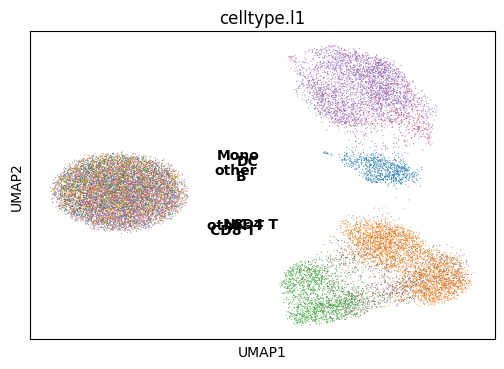

C:\Users\vinee\miniconda3\envs\scvi\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
C:\Users\vinee\miniconda3\envs\scvi\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


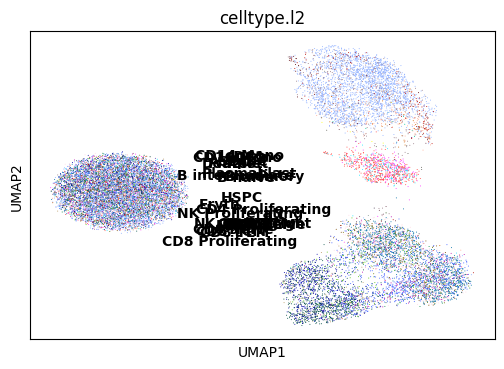

C:\Users\vinee\miniconda3\envs\scvi\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
C:\Users\vinee\miniconda3\envs\scvi\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


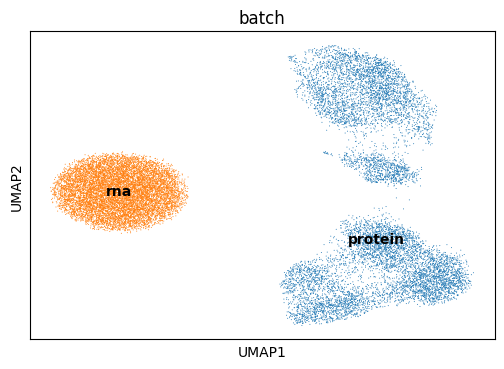

euclidean metric will be used for calculating the distance!
Start the matching process...
Computing the distance matrix...
Getting matchings by Minimum Distance...
Linear assignment completed!


C:\Users\vinee\Desktop\cs690\vineet_ugp\scVI\metrics\match_utils.py:41: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return np.mean([labels1[i] == labels2[j] for i, j in zip(matching[0], matching[1])])


For All matchings: lv1 matching acc: 0.207,
lv2 matching acc: 0.043.
For All matchings: FOSCTTM score: 0.49534815, 
Knn Alignment score: [0.     0.0002 0.0003 0.0005 0.0006 0.0006 0.0007 0.0008 0.0012 0.0012
 0.0012 0.0013 0.0013 0.0014 0.0015 0.0016 0.0017 0.0017 0.002  0.002
 0.0021 0.0022 0.0023 0.0023 0.0026]
For All matchings: Silhouette F1 score for lv1: 0.34166465275664365, 
Silhouette F1 score for lv2: 0.3357226890042097


C:\Users\vinee\Desktop\cs690\vineet_ugp\scVI\metrics\match_utils.py:423: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  cm = confusion_matrix(labels_l1[matchings[0]], labels_l1[matchings[1]])





Matches are being filtered...
Matchings before filtering:  10000
Threshold distance for filtering the matchings:  7.263002157211304
Matchings are reduced to 5000 after filtering...


C:\Users\vinee\Desktop\cs690\vineet_ugp\scVI\metrics\match_utils.py:41: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return np.mean([labels1[i] == labels2[j] for i, j in zip(matching[0], matching[1])])


For only filtered matchings: lv1 matching acc: 0.206,
lv2 matching acc: 0.042.



Matches are being propagated....


C:\Users\vinee\Desktop\cs690\vineet_ugp\scVI\metrics\match_utils.py:460: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  cm = confusion_matrix(labels_l1[filtered_matchings[0]], labels_l1[filtered_matchings[1]])
C:\Users\vinee\miniconda3\envs\scvi\lib\site-packages\scipy\sparse\_index.py:143: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


Done!


C:\Users\vinee\Desktop\cs690\vineet_ugp\scVI\metrics\match_utils.py:41: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return np.mean([labels1[i] == labels2[j] for i, j in zip(matching[0], matching[1])])


For all matchings after propagation: lv1 matching acc: 0.240,
lv2 matching acc: 0.088.


C:\Users\vinee\Desktop\cs690\vineet_ugp\scVI\metrics\match_utils.py:495: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  cm = confusion_matrix(labels_l1[propagated_matchings[0]], labels_l1[propagated_matchings[1]])


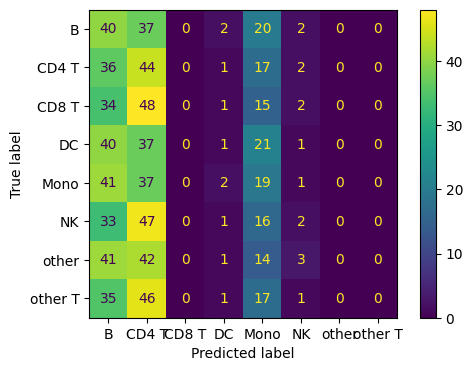

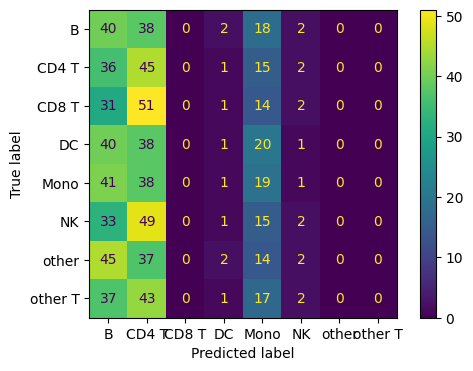

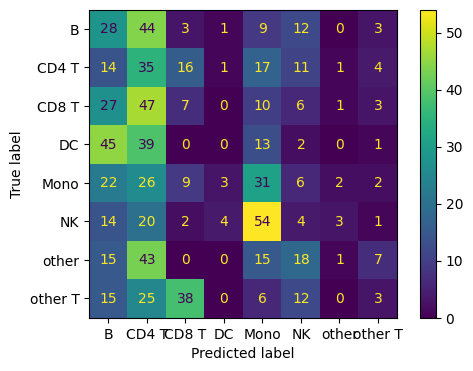

Epoch: 1: 0it [00:00, ?it/s]C:\Users\vinee\AppData\Local\Temp\ipykernel_1344\3129631169.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return {"x_unshared":self.unshared_data[idx], "x_shared":self.shared_data[idx], "l1":self.labels_l1[idx], "l2":self.labels_l2[idx], "mean": self.local_mean[idx], "var": self.local_var[idx], "batch": self.batch[idx]}
Epoch: 1: 40it [00:12,  3.21it/s]
Epoch: 2: 40it [00:12,  3.27it/s]
Epoch: 3: 40it [00:12,  3.09it/s]
Epoch: 4: 40it [00:12,  3.23it/s]
Epoch: 5: 40it [00:12,  3.28it/s]
Epoch: 6: 40it [00:12,  3.26it/s]
Epoch: 7: 40it [00:12,  3.25it/s]
Epoch: 8: 40it [00:12,  3.23it/s]
Epoch: 9: 40it [00:12,  3.24it/s]
Epoch: 10: 40it [00:12,  3.24it/s]
Epoch: 11: 40it [00:12,  3.22it/s]
Epoch: 12: 40it [00:12,  3.22it/s]
Epoch: 13: 40it [00:12,  3.24it/s]
Epoch: 14

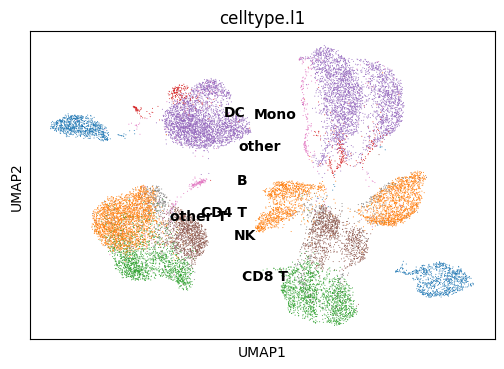

C:\Users\vinee\miniconda3\envs\scvi\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
C:\Users\vinee\miniconda3\envs\scvi\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


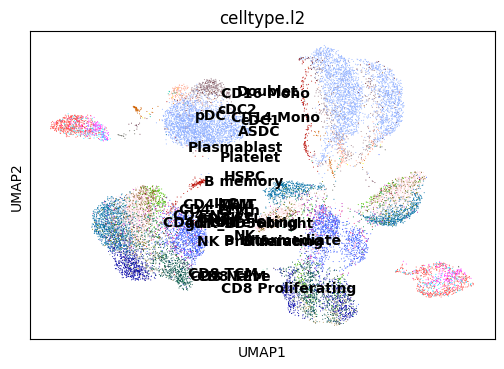

C:\Users\vinee\miniconda3\envs\scvi\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
C:\Users\vinee\miniconda3\envs\scvi\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


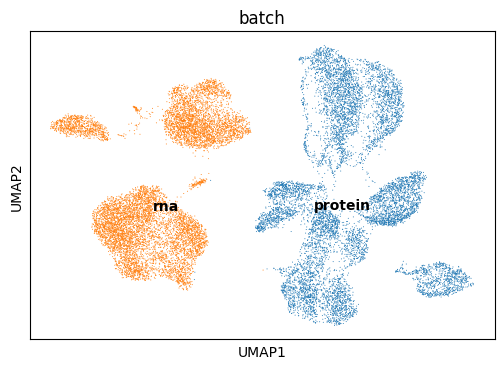

euclidean metric will be used for calculating the distance!
Start the matching process...
Computing the distance matrix...
Getting matchings by Minimum Distance...
Linear assignment completed!


C:\Users\vinee\Desktop\cs690\vineet_ugp\scVI\metrics\match_utils.py:41: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return np.mean([labels1[i] == labels2[j] for i, j in zip(matching[0], matching[1])])


For All matchings: lv1 matching acc: 0.141,
lv2 matching acc: 0.072.
For All matchings: FOSCTTM score: 0.46310527999999995, 
Knn Alignment score: [0.0002 0.0004 0.0008 0.001  0.0013 0.0015 0.0015 0.0016 0.0019 0.0021
 0.0023 0.0025 0.003  0.003  0.0034 0.0036 0.0038 0.0041 0.0042 0.0043
 0.0045 0.0046 0.0047 0.0048 0.0049]
For All matchings: Silhouette F1 score for lv1: 0.3488883327555165, 
Silhouette F1 score for lv2: 0.33544739580847505



Matches are being filtered...
Matchings before filtering:  10000
Threshold distance for filtering the matchings:  6.562906980514526
Matchings are reduced to 5000 after filtering...


C:\Users\vinee\Desktop\cs690\vineet_ugp\scVI\metrics\match_utils.py:423: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  cm = confusion_matrix(labels_l1[matchings[0]], labels_l1[matchings[1]])
C:\Users\vinee\Desktop\cs690\vineet_ugp\scVI\metrics\match_utils.py:41: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return np.mean([labels1[i] == labels2[j] for i, j in zip(matching[0], matching[1])])


For only filtered matchings: lv1 matching acc: 0.072,
lv2 matching acc: 0.054.



Matches are being propagated....


C:\Users\vinee\Desktop\cs690\vineet_ugp\scVI\metrics\match_utils.py:460: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  cm = confusion_matrix(labels_l1[filtered_matchings[0]], labels_l1[filtered_matchings[1]])
C:\Users\vinee\miniconda3\envs\scvi\lib\site-packages\scipy\sparse\_index.py:143: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


Done!


C:\Users\vinee\Desktop\cs690\vineet_ugp\scVI\metrics\match_utils.py:41: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return np.mean([labels1[i] == labels2[j] for i, j in zip(matching[0], matching[1])])


For all matchings after propagation: lv1 matching acc: 0.347,
lv2 matching acc: 0.183.


C:\Users\vinee\Desktop\cs690\vineet_ugp\scVI\metrics\match_utils.py:495: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  cm = confusion_matrix(labels_l1[propagated_matchings[0]], labels_l1[propagated_matchings[1]])


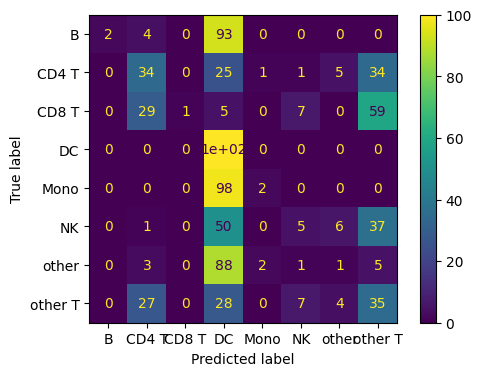

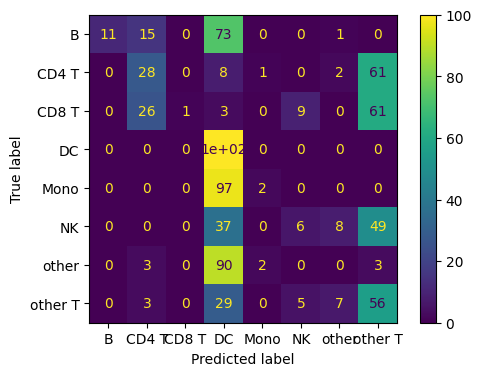

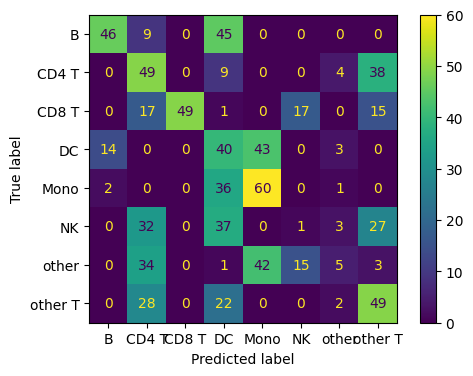

Epoch: 41: 0it [00:00, ?it/s]C:\Users\vinee\AppData\Local\Temp\ipykernel_1344\3129631169.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return {"x_unshared":self.unshared_data[idx], "x_shared":self.shared_data[idx], "l1":self.labels_l1[idx], "l2":self.labels_l2[idx], "mean": self.local_mean[idx], "var": self.local_var[idx], "batch": self.batch[idx]}
Epoch: 41: 40it [00:12,  3.19it/s]
Epoch: 42: 40it [00:12,  3.21it/s]
Epoch: 43: 40it [00:12,  3.23it/s]
Epoch: 44: 40it [00:12,  3.23it/s]
Epoch: 45: 40it [00:12,  3.23it/s]
Epoch: 46: 40it [00:12,  3.17it/s]
Epoch: 47: 40it [00:12,  3.22it/s]
Epoch: 48: 40it [00:12,  3.22it/s]
Epoch: 49: 40it [00:12,  3.21it/s]
Epoch: 50: 40it [00:12,  3.21it/s]
Epoch: 51: 40it [00:12,  3.20it/s]
Epoch: 52: 40it [00:13,  2.93it/s]
Epoch: 53: 40it [00:12,  3.20it/s]

In [ ]:
kl_weight = 0.0
metrics = {
    'original': {
        'lv1_acc': [],
        'lv2_acc': [],
        'foscttm_score': []
    },
    'filtered':{
        'lv1_acc': [],
        'lv2_acc': [],
        'foscttm_score': []
    },
    'propagated':{
        'lv1_acc': [],
        'lv2_acc': [],
        'foscttm_score': []
    }
}
for epoch in range(1001):
    loss = 0.0
    rna_recon_loss_piter = 0.0
    rna_kl_div_l_piter = 0.0
    rna_kl_div_z_piter = 0.0
    pro_recon_loss_piter = 0.0
    pro_kl_div_back_pro_piter = 0.0
    pro_kl_div_z_piter = 0.0
    for batchr, batchp in tqdm(zip(rna_dataloader, protein_dataloader), desc="Epoch: {}".format(epoch)):
        optimizer_p.zero_grad()
        optimizer_r.zero_grad()
        optimizer_pr.zero_grad()
        
        y_shared = batchp["y_shared"].to(device)
        x_shared = batchr["x_shared"].to(device)
        y_unshared = batchp["y_unshared"].to(device)
        x_unshared = batchr["x_unshared"].to(device)
        x_batch = batchr["batch"].to(device)
        y_batch = batchp["batch"].to(device)
        # local_mean = rna_dataset.local_mean.reshape(-1,1).expand(x_shared.shape[0], 1).to(device)
        # local_var = rna_dataset.local_var.reshape(-1,1).expand(x_shared.shape[0], 1).to(device)
        local_mean = batchr["mean"].to(device)
        local_var = batchr["var"].to(device)
    
        ## forward pass of unshared network of proteins and rna
        pro_recon_loss, pro_kl_div_z, pro_kl_div_back_pro, z_pro = podel(y_unshared)
        rna_recon_loss, rna_kl_div_l, rna_kl_div_z, z_rna = rodel(x_unshared, local_mean, local_var)
        unshared_protein_loss = torch.mean(pro_recon_loss + kl_weight*pro_kl_div_z + pro_kl_div_back_pro)
        unshared_rna_loss = torch.mean(rna_recon_loss + rna_kl_div_l + kl_weight*rna_kl_div_z)
        with torch.no_grad():
            _, _, _, _, _, z_gene, z_protein = prodel(x_shared,y_shared,local_mean,local_var,x_batch,y_batch)
        loss_embedd_p = CLIP_loss(z_pro,z_protein)
        loss_embedd_r = CLIP_loss(z_rna,z_gene)
        loss_pro = unshared_protein_loss + loss_embedd_p
        loss_rna = unshared_rna_loss + loss_embedd_r
        loss_rna.backward()
        optimizer_r.step()
        loss_pro.backward()
        optimizer_p.step()
        
        ## forward pass of shared_network
        outputs = prodel(x_shared,y_shared,local_mean,local_var,x_batch,y_batch)
        shared_loss = torch.mean(outputs[0] + outputs[3]) + kl_weight*torch.mean(outputs[2]) + torch.mean(outputs[1] + outputs[4])
        with torch.no_grad():
            _, _, _, z_pro = podel(y_unshared)
            _, _, _, z_rna = rodel(x_unshared,local_mean,local_var)
        loss_embedd_p = CLIP_loss(z_pro,outputs[-1])
        loss_embedd_r = CLIP_loss(z_rna,outputs[-2])
        loss = shared_loss + loss_embedd_p + loss_embedd_r
        loss.backward()
        optimizer_pr.step()
        
    kl_weight = min(1.0,(epoch+1)/1000)    
    if epoch % 40 == 0:
        """Testing loop and visualisation saving"""
        with torch.no_grad():
            shared_rna_data = torch.Tensor(rna_dataset.shared_data)
            shared_pro_data = torch.Tensor(protein_dataset.shared_data)
            labelsl1 = rna_dataset.labels_l1
            labelsl2 = rna_dataset.labels_l2
            shared_tensor_mean = torch.Tensor(rna_dataset.local_mean).to(device)
            shared_tensor_var = torch.Tensor(rna_dataset.local_var).to(device)
            x_batch = torch.Tensor(rna_dataset.batch).to(device)
            y_batch = torch.Tensor(protein_dataset.batch).to(device)
            _, _, _, _, _, z_gene, z_pro = prodel(shared_rna_data, shared_pro_data, shared_tensor_mean, shared_tensor_var, x_batch, y_batch)
            adata_plot = ad.AnnData(X= np.concatenate([z_gene.numpy(), z_pro.numpy()], axis=0))
            adata_plot.obs['celltype.l1'] = np.concatenate([labelsl1,labels_l1], axis=0)
            adata_plot.obs['celltype.l2'] = np.concatenate([labelsl2,labels_l2], axis=0)
            adata_plot.obs['batch'] = np.concatenate([["rna"]*z_gene.shape[0], ["protein"]*z_pro.shape[0]], axis=0)
            sc.pp.neighbors(adata_plot)
            sc.tl.umap(adata_plot)
            sc.pl.umap(adata_plot, color='celltype.l1', legend_loc='on data', s=2)            
            sc.pl.umap(adata_plot, color='celltype.l2', legend_loc='on data', s=2)
            sc.pl.umap(adata_plot, color='batch', legend_loc='on data', s=2)            
            met = mu.get_all_metrics(z_gene, z_pro, labelsl1, labelsl2, dim_use = 20, k_max=25, metric='euclidean', assignment_type='mindist', filter_prop=0.5, verbose=True)
            metrics['original']['lv1_acc'].append(met['original']['lv1_acc'])
            metrics['original']['lv2_acc'].append(met['original']['lv2_acc'])
            metrics['original']['foscttm_score'].append(met['original']['foscttm_score'])
            metrics['filtered']['lv1_acc'].append(met['filtered']['lv1_acc'])
            metrics['filtered']['lv2_acc'].append(met['filtered']['lv2_acc'])
            metrics['filtered']['foscttm_score'].append(met['filtered']['foscttm_score'])
            metrics['propagated']['lv1_acc'].append(met['propagated']['lv1_acc'])
            metrics['propagated']['lv2_acc'].append(met['propagated']['lv2_acc'])
            metrics['propagated']['foscttm_score'].append(met['propagated']['foscttm_score'])

In [ ]:
# Create subplots
fig, axs = plt.subplots(3, 3, figsize=(15, 10))

# Plot each metric on a separate subfigure
for i, (category, submetrics) in enumerate(metrics.items()):
    for j, (metric_name, values) in enumerate(submetrics.items()):
        ax = axs[i, j]
        ax.plot(values, label=metric_name)
        ax.set_title(f'{category.capitalize()} - {metric_name}')
        ax.set_xlabel('Epochs')
        ax.set_ylabel('Value')
        ax.legend()

# Adjust layout and show the plot
plt.tight_layout()
plt.show()